# Solve surface volatiles according to outgassing+chemistry

In [1]:
import sys
sys.path.append("..") 
from utils.surface_gases import *

from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

### Set up initial options dict

In [2]:
COUPLER_options = {}

COUPLER_options['Phi_global'] = 0.5
COUPLER_options['T_outgas'] = 1500.0

COUPLER_options['radius'] = 6.371e6 * 1.875
COUPLER_options['mass']   = 5.972e24 * 7.99
COUPLER_options['gravity'] = 6.67e-11 * COUPLER_options['mass'] / (COUPLER_options['radius']**2)
COUPLER_options['hydrogen_earth_oceans'] = 8.0
COUPLER_options['CH_ratio'] = 1.0
COUPLER_options['fO2_shift_IW'] = 0.0
COUPLER_options['nitrogen_ppmw'] = 4.0
COUPLER_options['sulfur_ppmw'] = 200.0
COUPLER_options['planet_coresize'] = 0.5

solvevol_vols = ['H2O', 'CO2', 'N2', 'H2', 'CO', 'CH4', 'S2', 'SO2']
for v in solvevol_vols:
    COUPLER_options[v+"_included"] = 0
    COUPLER_options[v+"_initial_bar"] = 0.0

COUPLER_options["H2O_included"] = 1
COUPLER_options["CO2_included"] = 1
COUPLER_options["N2_included"]  = 1
COUPLER_options["S2_included"]  = 1

COUPLER_options["H2_included"]  = 1
COUPLER_options["CO_included"]  = 1
COUPLER_options["CH4_included"] = 1
COUPLER_options["SO2_included"] = 1

# COUPLER_options["H2O_initial_bar"] = 1.0
# COUPLER_options["CO2_initial_bar"] = 0.0
# COUPLER_options["N2_initial_bar"]  = 0.0

print("Gravity = %.3f m.s-2" % COUPLER_options["gravity"])



Gravity = 22.304 m.s-2


### Calculate total amount of each element in the system

In [3]:
COUPLER_options["mantle_mass"] = calc_mantle_mass(COUPLER_options)
BACKUP_options = deepcopy(COUPLER_options)

In [4]:
solvevol_target = solvevol_get_target_from_params(COUPLER_options)
# solvevol_target = solvevol_get_target_from_pressures(COUPLER_options)

print("Targets:")
print(solvevol_target)

Targets:
{'H': 1.24e+21, 'C': 1.24e+21, 'N': 1.5241054973730108e+20, 'S': 7.620527486865053e+21}


### Solve for equilibrium atmospheric partial pressures, etc.

In [5]:
p_d = solvevol_equilibrium_atmosphere(solvevol_target, COUPLER_options)

print(p_d)

p_bar = {}
for v in volatile_species:
    p_bar[v] = p_d[v+"_atm_bar"]

mubar = 0.0
ptot = 0.0
print("Partial pressures")
for v in solvevol_vols:
    print("    %s : %.3f bar"%(v, p_bar[v]))
    ptot += p_bar[v]
    mubar += p_bar[v]*molar_mass[v]
mubar /= ptot

print("mubar =",mubar)
print("ptot = %.3f bar"%ptot)

m_d = {}
for v in solvevol_vols:
    m_d[v] = p_bar[v]*1.0e5 * 4 * 3.14 * (molar_mass[v]/mubar) * COUPLER_options["radius"]**2.0 / COUPLER_options["gravity"]

# print(solvevol_atmosphere_mass(p_bar, COUPLER_options))

print(" ")
print(m_d)

H_kg = (2*m_d["H2O"]/molar_mass["H2O"] + 2*m_d["H2"]/molar_mass["H2"] + 4*m_d["CH4"]/molar_mass["CH4"]) *molar_mass['H']
C_kg = (m_d["CO2"]/molar_mass["CO2"] + m_d["CO"]/molar_mass["CO"] + m_d["CH4"]/molar_mass["CH4"]) * molar_mass['C']
N_kg = m_d["N2"]
S_kg = m_d["S2"]

print(H_kg, C_kg, N_kg, S_kg)


{'M_atm': 2.548019507221731e+21, 'P_surf': 316.92010288358324, 'H2O_atm_bar': 1.229666007663201, 'H2O_atm_kg': 5.550864212641444e+18, 'H2O_liquid_kg': 1.1070058436538592e+22, 'H2O_solid_kg': 0.0, 'H2O_total_kg': 1.1075609300751232e+22, 'CO2_atm_bar': 83.3788042390158, 'CO2_atm_kg': 9.194739940984555e+20, 'CO2_liquid_kg': 7.147509909743863e+20, 'CO2_solid_kg': 0.0, 'CO2_total_kg': 1.6342249850728418e+21, 'H2_atm_bar': 1.1530231365266315, 'H2_atm_kg': 5.82418440882604e+17, 'H2_liquid_kg': 0.0, 'H2_solid_kg': 0.0, 'H2_total_kg': 5.82418440882604e+17, 'CH4_atm_bar': 0.0013299368553784776, 'CH4_atm_kg': 5345247323286866.0, 'CH4_liquid_kg': 350610730306390.94, 'CH4_solid_kg': 0.0, 'CH4_total_kg': 5695858053593257.0, 'CO_atm_bar': 211.81978680413403, 'CO_atm_kg': 1.486661363383311e+21, 'CO_liquid_kg': 3.649482338669119e+20, 'CO_solid_kg': 0.0, 'CO_total_kg': 1.851609597250223e+21, 'N2_atm_bar': 19.33687686297251, 'N2_atm_kg': 1.3573563385163101e+20, 'N2_liquid_kg': 1.6674915885573014e+19, 'N2

/Users/nichollsh/Projects/PROTEUS/tools/../utils/surface_gases.py:266: RuntimeWarning: invalid value encountered in scalar power
  p_d['SO2']  = (gamma*pin['S2']*p_d['O2']**2)**0.5
/Users/nichollsh/Projects/PROTEUS/tools/../utils/surface_gases.py:135: RuntimeWarning: invalid value encountered in log
  out = 13.8426 - 26.476e3/temp + 0.124*x_FeO + 0.5*np.log(p/fO2)


### Check results

In [6]:
H_mol = H_kg / (1.0e-3)
H_oc  = H_mol / (7.69e22 * 2.0)


print("[H] atm = %.4f" % H_oc)
print("C/H atm = %.4f" % (C_kg/H_kg))

[H] atm = 0.0078
C/H atm = 737.3148


### Parameter sweep demo

/Users/nichollsh/Projects/PROTEUS/tools/../utils/surface_gases.py:266: RuntimeWarning: invalid value encountered in scalar power
  p_d['SO2']  = (gamma*pin['S2']*p_d['O2']**2)**0.5
/Users/nichollsh/Projects/PROTEUS/tools/../utils/surface_gases.py:183: RuntimeWarning: invalid value encountered in scalar power
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/Users/nichollsh/Projects/PROTEUS/tools/../utils/surface_gases.py:135: RuntimeWarning: invalid value encountered in log
  out = 13.8426 - 26.476e3/temp + 0.124*x_FeO + 0.5*np.log(p/fO2)
/Users/nichollsh/Projects/PROTEUS/tools/../utils/surface_gases.py:81: RuntimeWarning: invalid value encountered in scalar power
  return const*p**exponent
/Users/nichollsh/Projects/PROTEUS/tools/../utils/surface_gases.py:210: RuntimeWarning: invalid value encountered in log10
  ppmw = 10 ** (-0.738 + 0.876 * np.log10(p) - 5.44e-5 * p_total)
/Users/nichollsh/Projects/PROTEUS/tools/../utils/surface_gases.py:183: RuntimeWarning: o

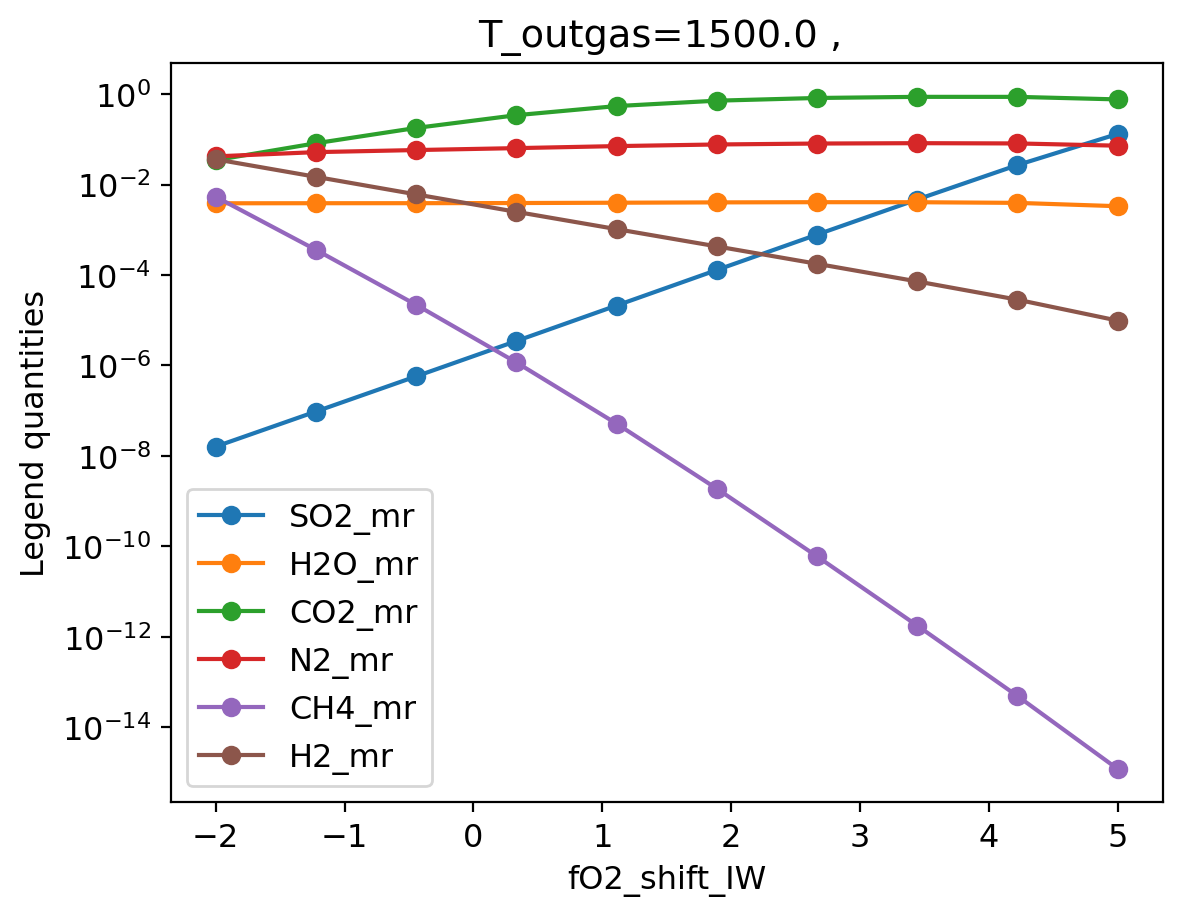

In [12]:
plt.close("all")

x_arr = np.linspace(-2, 5, 10)
x_key = "fO2_shift_IW"
y_keys = ["SO2_mr", "H2O_mr", "CO2_mr", "N2_mr", "CH4_mr", "H2_mr"]
# y_keys = ["C_outgassed_frac"]

y_out = {}
for y in y_keys:
    y_out[y] = []

for x in x_arr:
    COUPLER_options = deepcopy(BACKUP_options)
    COUPLER_options[x_key] = x
    solvevol_target = solvevol_get_target_from_params(COUPLER_options)
    p_d = solvevol_equilibrium_atmosphere(solvevol_target, COUPLER_options)
    for y in y_keys:
        y_out[y].append(p_d[y])


fig,ax = plt.subplots(1,1)

for y in y_keys:
    ax.plot(x_arr, y_out[y], marker='o', label=y)
ax.set(xlabel=x_key, ylabel="Legend quantities")
ax.legend()
ax.set_yscale("log")

title_keys = ["fO2_shift_IW", "T_outgas"]
title = ""
for t in title_keys:
    if t != x_key:
        title += t+"=%.1f , "%COUPLER_options[t]
ax.set_title(title)

plt.show()